In [1]:
# Load packages
rm(list=ls())
gc()
getwd()
.libPaths('/home/zhangheng/rpackages')
options(width=2000)

# Load libraries
# library(Rcpp)
library(readxl)
# library(dplyr)
library(data.table)
library(ggplot2)
library(causalTree)
library(data.table)
library(rpart)
library(rattle)
# detach(treeClust)

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,513697,27.5,1153892,61.7,627625,33.6
Vcells,1010285,7.8,8388608,64.0,1759718,13.5


[1] "/home/zhangheng/causal-tree-minicourse"

Loading required package: rpart
Loading required package: rpart.plot
Rattle: A free graphical interface for data science with R.
Version 5.2.0 Copyright (c) 2006-2018 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.


In [2]:
### Load in data
df<-fread("follow_page_clean_300W.csv")

In [3]:
# Clean data
df <- transform(df, is_new_user = as.factor(is_new_user))
df <- transform(df, install_douyin = as.factor(install_douyin))
df <- transform(df, is_photo_author = as.factor(is_photo_author))
sapply(df, class)

user_id       treatment        app_time          gender             age            days     is_new_user  install_douyin is_photo_author        cum_fans      cum_follow       cum_bidir         h_photo         f_photo         n_photo         p_photo        like_cnt     comment_dur      follow_cnt          d_live          f_live          n_live          p_live 
      "integer"       "integer"       "numeric"     "character"     "character"       "numeric"        "factor"        "factor"        "factor"       "integer"       "integer"       "integer"       "numeric"       "numeric"       "numeric"       "numeric"       "numeric"       "numeric"       "numeric"       "numeric"       "numeric"       "numeric"       "numeric"

# Build the tree with various method

In this part, we build the tree. 

In [4]:
#### Produce the tree
df$log_app_time = log(df$app_time+0.001) 
tree <- honest.causalTree(log_app_time ~ age + is_new_user +  install_douyin + is_photo_author,
    data = df[2000000:2005000, ],
    treatment = df[2000000:2005000, ]$treatment,
    est_data = df[1500000:2000000, ],
    est_treatment = df[1500000:2000000, ]$treatment,
    HonestSampleSize = df[1500000:2000000, ]$treatment,
    split.Rule = "fit", 
    split.Honest = T, 
    cv.option = "CT", 
    cv.Honest = T,
    split.Bucket = F, xval = 10)

[1] 3
[1] "fit"


Warning message in if (HonestSampleSize != est_nobs) {:
“the condition has length > 1 and only the first element will be used”Warning message in honest.causalTree(log_app_time ~ age + is_new_user + install_douyin + :
“HonestSampleSize shoud be the number of observations in estimation sample.”

In [5]:
# Print the result for cross valication
head(tree$cptable)
tree$cptable

,CP,nsplit,rel error,xerror,xstd
1,1.713140e-04,0,1.0000000,1.0000000,4.040883e-06
2,3.291483e-05,1,0.9998287,0.9999673,9.408948e-06
3,2.499724e-05,2,0.9997958,0.9999628,1.345035e-05
4,1.270272e-05,3,0.9997708,0.9999134,4.709123e-05
5,9.553955e-06,4,0.9997581,0.9999395,5.236428e-05
6,8.601596e-06,5,0.9997485,0.9999349,5.497538e-05


,CP,nsplit,rel error,xerror,xstd
1,1.713140e-04,0,1.0000000,1.0000000,4.040883e-06
2,3.291483e-05,1,0.9998287,0.9999673,9.408948e-06
3,2.499724e-05,2,0.9997958,0.9999628,1.345035e-05
4,1.270272e-05,3,0.9997708,0.9999134,4.709123e-05
5,9.553955e-06,4,0.9997581,0.9999395,5.236428e-05
6,8.601596e-06,5,0.9997485,0.9999349,5.497538e-05
7,7.048536e-06,6,0.9997399,0.9999351,5.515257e-05
8,6.817208e-06,7,0.9997329,0.9999408,5.533524e-05
9,1.386953e-06,8,0.9997260,0.9998341,1.044924e-04
10,1.174205e-06,9,0.9997247,0.9997481,1.098812e-04


Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”

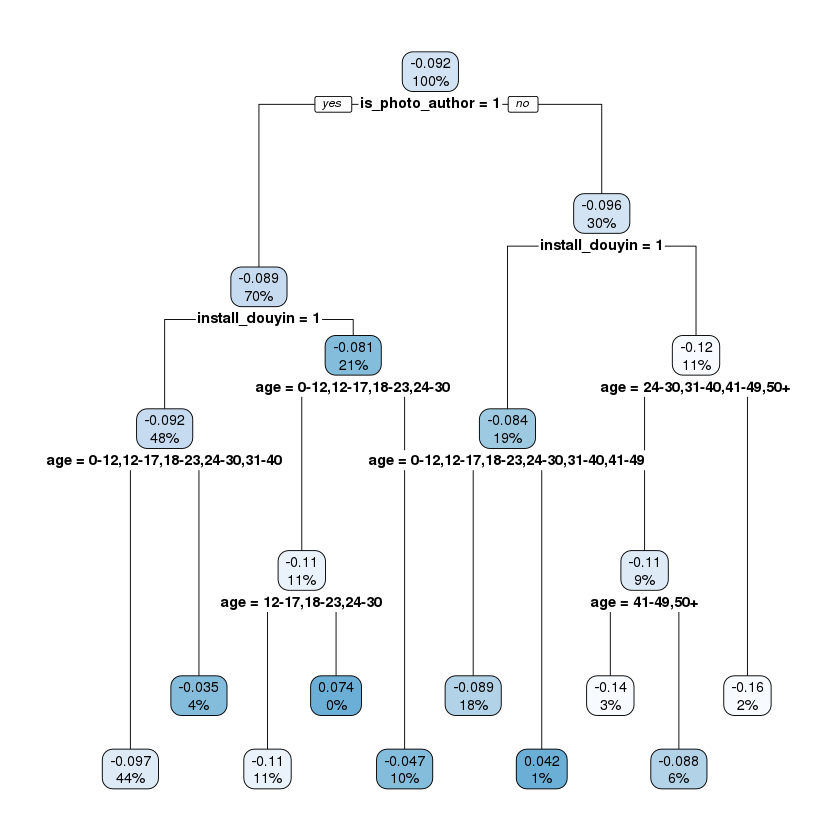

In [6]:
# Prune the tree and plot
opcp <- tree$cptable[, 1][10]
optree <- prune(tree, cp = opcp)
rpart.plot(optree)
# which.min(tree$cptable[,4])

In [28]:
# Get the node member ship of each of the users
library(treeClust)
temp = df
temp$where = rpart.predict.leaves(optree, newdata = temp, type = "where")

In [29]:
# Write the data into csv
fwrite(temp, "data_with_node_info.csv")